In [24]:
import gc
import logging
import os
import shutil

import matplotlib.pyplot as plt
import mlflow as mlf
import numpy as np
import pandas as pd
import pingouin as pg
import scipy.stats as st
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as krs
import tensorflow_probability as tfp
from tqdm.auto import tqdm
from IPython.display import display

import src.algorithms.advantages as adv
import src.algorithms.algo_utils as autil
import src.algorithms.dummy as dummy
import src.algorithms.policy_gradient.tf2.ac as ac
import src.algorithms.policy_gradient.tf2.ppo as ppo
import src.algorithms.policy_gradient.tf2.vpg as vpg
import src.models.base_models.tf2.policy_nets as policy_nets
import src.models.base_models.tf2.value_nets as vnets
import src.utils as util
from src.envs.resource_allocation_env import DiscreteProjectsEnv, DiscreteProjectOptimizerAgent
from typing import Tuple
from stable_baselines3.ppo import PPO, MlpPolicy
from stable_baselines3.a2c import A2C, MlpPolicy

# Env setup

In [5]:
ENV_SIZE = 300

In [7]:
def build_env(start_resource=100,
              start_cash=100,
              upkeep_cost=-1,
              min_payout=-0.5,
              max_payout=1.5,
              payout_mean=1.,
              payout_std=0.5,
              size=300,
              balance_is_reward=False,
              stochastic=True,
              *args,
              **kwargs):
    return DiscreteProjectsEnv(
        start_resource=start_resource,
        start_cash=start_cash,
        upkeep_cost=upkeep_cost,
        min_payout=min_payout,
        max_payout=max_payout,
        payout_mean=payout_mean,
        payout_std=payout_std,
        size=size,
        balance_is_reward=balance_is_reward,
        stochastic=stochastic, *args, **kwargs)

In [12]:
EASY_ENV = 'easy'
MEDIUM_ENV = 'medium'
HARD_ENV = 'hard'

In [13]:
env_easy = build_env(distrib_prob=tfp.distributions.TruncatedNormal(0.7, 0.2, 0.0, 1.0))
env_medium = build_env(distrib_prob=tfp.distributions.TruncatedNormal(0.5, 0.2, 0.0, 1.0))
env_hard = build_env(distrib_prob=tfp.distributions.TruncatedNormal(0.3, 0.2, 0.0, 1.0))

C:\Users\fwojcik\Anaconda3\envs\py39\lib\site-packages\gym\logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


Text(0.5, 6.79999999999999, 'success probability')

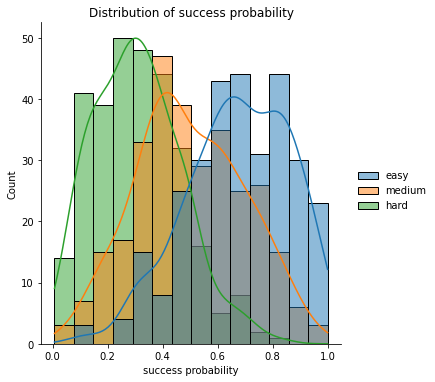

In [14]:
probabilities = pd.DataFrame({
    'easy': env_easy.projects.proj_1_proba,
    'medium': env_medium.projects.proj_1_proba,
    'hard': env_hard.projects.proj_1_proba,
})
sns.displot(probabilities, kde='kde')
plt.title("Distribution of success probability")
plt.xlabel("success probability")

# Agents prep

In [95]:
BASELINE_AGENT = 'baseline'
RANDOM_AGENT = 'random'
PPO_AGENT = 'ppo'
AC_AGENT = 'ac'

## SB3 wrapper

In [19]:
class BaselinesWrapper:

    def __init__(self, baselines_agent):
        self.agent = baselines_agent

    def choose_action(self, s: np.array, *args, **kwargs) -> Tuple[np.array, np.array]:
        return self.agent.predict(s)

## Utility functions

In [25]:
def evaluate_agents(env, agents: dict, n_episodes: int = 500, sb3: bool = False) -> dict:
    results = {}
    for a_name, agent in agents.items():
        agent2eval = agent if not sb3 else BaselinesWrapper(agent)
        score = autil.evaluate_algorithm(agent2eval, env, n_episodes, max_ep_steps=ENV_SIZE, clip_action=False)
        results[a_name] = score
    return results


In [99]:
def summarize_experiment(all_scores_after: pd.DataFrame, env_name: str, results_dir: str = 'proj_alloc_discrete_sb3'):
    if not os.path.exists(results_dir):
        os.mkdir(results_dir)
    all_scores_after.to_csv(os.path.join(results_dir, f"{env_name}_scores.csv"), index=False)
    all_scores_melted = all_scores_after.melt(var_name='model', value_name='score')
    welch_anova = pg.welch_anova(all_scores_melted, dv='score', between='model')
    pairwise_res = pg.pairwise_gameshowell(all_scores_melted, dv='score', between='model')
    welch_anova.to_csv(os.path.join(results_dir, f"{env_name}_welch_results.csv"), index=False)
    pairwise_res.to_csv(os.path.join(results_dir, f"{env_name}_pairwise_test.csv"), index=False)

    sns.histplot(data=all_scores_melted, x='score', hue='model', bins=20)
    plt.title(f"Scores distribution {env_name}")
    plt.savefig(os.path.join(results_dir, f"{env_name}_scores.png"))
    plt.show()

    display(welch_anova)
    display(pairwise_res)

In [112]:
def perform_experiment(env, env_name, dummy_agents_builders: dict, rl_agents_builders: dict,
                       results_dir: str = 'proj_alloc_discrete_sb3'):
    rl_agents = {a_name: a_factory(env) for a_name, a_factory in rl_agents_builders.items()}
    dummy_agents = {a_name: a_factory(env) for a_name, a_factory in dummy_agents_builders.items()}
    rl_scores_before = evaluate_agents(env, rl_agents, sb3=True)
    dummy_scores = evaluate_agents(env, dummy_agents)

    for agent_name, agent in tqdm(rl_agents.items()):
        print(f"Training {agent_name}")
        agent.learn(total_timesteps=200000)

    rl_scores_after = evaluate_agents(env, rl_agents, sb3=True)

    all_scores_before = pd.DataFrame({**rl_scores_before, **dummy_scores})
    all_scores_after = pd.DataFrame({**rl_scores_after, **dummy_scores})
    summarize_experiment(all_scores_after, env_name, results_dir)
    return all_scores_before, all_scores_after

In [113]:
gc.collect()
baselne_agent_builder_f = lambda env: DiscreteProjectOptimizerAgent(env)
random_agent_builder_f = lambda env: dummy.DummyAgent(env)
policy_kwargs = dict(net_arch=[dict(pi=[128, 128], vf=[64, 64])])
ppo_builder_f = lambda env: PPO(MlpPolicy, env, policy_kwargs=policy_kwargs, verbose=0, ent_coef=0.001)
a2c_builder_f = lambda env: A2C(MlpPolicy, env, policy_kwargs=policy_kwargs, verbose=0)

In [114]:
rl_agent_factory = {PPO_AGENT: ppo_builder_f, AC_AGENT: a2c_builder_f}
dummy_agent_factory = {RANDOM_AGENT: random_agent_builder_f, BASELINE_AGENT: baselne_agent_builder_f}

# Experiment

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Training ppo
Training ac


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

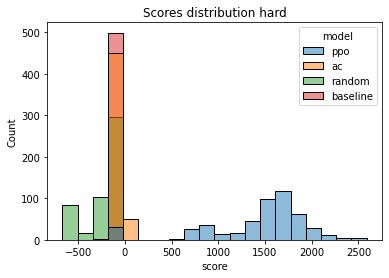

,Source,ddof1,ddof2,F,p-unc,np2
0,model,3,923.621361,1667.146039,0.0,0.845465


,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,ac,baseline,-64.153210,-119.139440,54.986230,1.835328,29.959897,699.614181,0.001,1.893406
1,ac,ppo,-64.153210,1426.423844,-1490.577054,24.868429,-59.938529,503.513080,0.001,-3.787996
2,ac,random,-64.153210,-241.627639,177.474429,8.080722,21.962696,543.358990,0.001,1.387999
3,baseline,ppo,-119.139440,1426.423844,-1545.563284,24.824161,-62.260445,499.947179,0.001,-3.934736
4,baseline,random,-119.139440,-241.627639,122.488199,7.943440,15.420044,508.327274,0.001,0.974516
5,ppo,random,1426.423844,-241.627639,1668.051483,26.041670,64.053168,599.303334,0.001,4.048033


In [115]:
_, scores_hard = perform_experiment(env_hard, 'hard', dummy_agent_factory, rl_agent_factory)

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Training ppo
Training ac


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

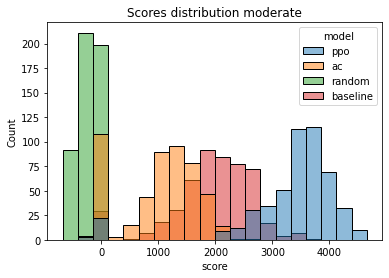

,Source,ddof1,ddof2,F,p-unc,np2
0,model,3,908.348009,4038.665345,0.0,0.784017


,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,ac,baseline,997.258142,1949.006363,-951.748221,44.826021,-21.232048,996.568978,0.001,-1.341823
1,ac,ppo,997.258142,3321.106955,-2323.848813,51.859116,-44.810806,924.887533,0.001,-2.831954
2,ac,random,997.258142,-261.784556,1259.042698,32.090097,39.234618,563.933240,0.001,2.479550
3,baseline,ppo,1949.006363,3321.106955,-1372.100592,52.588125,-26.091453,941.101834,0.001,-1.648928
4,baseline,random,1949.006363,-261.784556,2210.790919,33.255335,66.479286,559.227792,0.001,4.201359
5,ppo,random,3321.106955,-261.784556,3582.891510,42.260064,84.781970,535.539638,0.001,5.358052


In [106]:
_, scores_moderate = perform_experiment(env_medium, 'moderate', dummy_agent_factory, rl_agent_factory)

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Training ppo
Training ac


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

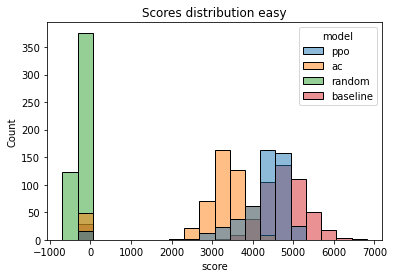

,Source,ddof1,ddof2,F,p-unc,np2
0,model,3,879.137228,7021.572296,0.0,0.794931


,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,ac,baseline,3040.614440,4521.866132,-1481.251693,74.437262,-19.899331,981.257763,0.001,-1.257598
1,ac,ppo,3040.614440,4175.598033,-1134.983594,64.485231,-17.600675,973.564074,0.001,-1.112328
2,ac,random,3040.614440,-257.226807,3297.841247,49.805794,66.214008,528.825531,0.001,4.184594
3,baseline,ppo,4521.866132,4175.598033,346.268099,69.872079,4.955743,923.906216,0.001,0.313193
4,baseline,random,4521.866132,-257.226807,4779.092940,56.607238,84.425474,521.942377,0.001,5.335522
5,ppo,random,4175.598033,-257.226807,4432.824840,42.682766,103.855144,540.022184,0.001,6.563439


In [108]:
_, scores_easy = perform_experiment(env_easy, 'easy', dummy_agent_factory, rl_agent_factory)

In [116]:
scores_hard.describe()

,ppo,ac,random,baseline
count,500.000000,500.000000,500.000000,500.000000
mean,1426.423844,-64.153210,-241.627639,-119.139440
std,554.821885,37.310344,176.796404,17.092457
min,-187.578730,-110.000000,-669.198550,-181.535860
25%,1272.324418,-103.000000,-300.000000,-127.834111
50%,1585.650789,-66.472069,-150.000000,-113.861075
75%,1755.174470,-47.448475,-100.000000,-104.611385
max,2587.856251,98.232441,-100.000000,-100.050122
